In [1]:
import os
import pandas as pd
import re
from wordcloud import WordCloud

In [2]:
files = [f for f in os.listdir(".\\Documents") if not f.startswith('.')]
files

['01 - Kraków.txt',
 '02 - Warszawa.txt',
 '03 - Wrocław.txt',
 '04 - Józefów.txt',
 '05 - Kokołaje.txt',
 '06 - Garwolin.txt',
 '07 - Epidemiologia otyłości na świecie i w Polsce.txt',
 '08 - Trendy w występowaniu nadwagi w Polsce.txt',
 '09 - Otyłość - choroba wagi ciężkiej.txt',
 '10 - Otyłość i jej konsekwencje.txt',
 '11 - Barcelona już świętowała mistrzostwo! Wtedy nadeszła 95. minuta meczu Realu.txt',
 '12 - 71 lat i koniec! Kylian Mbappe przeszedł do historii! Oto nowy rekord.txt',
 '13 - Oto dlaczego Wojciech Szczęsny musi odejść z Barcelony.txt',
 '14 - Pertkiewicz Nawet nie bierzemy pod uwagę transferów gotówkowych [WYWIAD].txt',
 '15 - Lewy bez gola, Szczęsny bez gry. Barcelona przegrywa i świętuje.txt',
 '16 - Carbonara ze szparagami.txt',
 '17 - Sałatka ze szparagów.txt',
 '18 - Żurek wegetariański.txt',
 '19 - Calzone.txt']

In [3]:
from pathlib import Path

corpus = pd.DataFrame(columns=['document'])
docs_path = Path('./Documents')

# Filtruj tylko pliki tekstowe i nie ukryte
text_files = [f for f in docs_path.glob('*.txt') if not f.name.startswith('.')]

for file_path in text_files:
    with open(file_path, mode="rt", encoding="utf-8") as f:
        txt = f.read()
    row = pd.DataFrame([{'document': txt}])
    corpus = pd.concat([corpus, row], ignore_index=True)

In [4]:
import spacy
import pl_core_news_md
nlp = pl_core_news_md.load()

In [11]:
removal = ['ADV', 'PRON', 'CCONJ', 'PUNCT', 'PART', 'DET', 'ADP', 'SPACE', 'NUM', 'SYM']
# Rozszerzony zestaw polskich stopwords
custom_stopwords = nlp.Defaults.stop_words.copy()
additional_stopwords = {
    'oraz', 'czyli', 'także', 'jednak', 'więc', 'bowiem',
    'natomiast', 'ponieważ', 'aby', 'iż', 'coś', 'taki',
    'który', 'jaki', 'kiedy', 'gdzie', 'być', 'mieć', 'rok',
    'móc', 'bardzo', 'jeden', 'dwa', 'trzy', 'cztery', 'pięć',
    'dzień', 'osoba', 'człowiek', 'ludzie', 'duży', 'mały',
    'nowy', 'stary', 'inny', 'każdy', 'wiele', 'więcej',
    'cały', 'wszystko', 'czas', 'podać', 'zostać', 'chcieć',
    'móc', 'dzięki', 'więcej', 'właśnie', 'należeć', 'nawet',
    'samej', 'sama', 'sam', 'mieszkaniec', 'mieszkać', 'lokalny',
    'życie', 'życia', 'ser', 'duży'
}
custom_stopwords.update(additional_stopwords)

# Lepszy proces tokenizacji
tokens = []
for txt in nlp.pipe(corpus['document']):
    # Utwórz listę tokenów dla jednego dokumentu
    proj_tok = []
    for token in txt:
        # Bardziej rygorystyczne filtrowanie
        if (token.pos_ not in removal and
            not token.is_stop and
            token.is_alpha and
            len(token.lemma_) > 2 and
            token.lemma_.lower() not in custom_stopwords):
            
            # Dodaj lemma do listy tokenów
            proj_tok.append(token.lemma_.lower())
    
    # Dodaj tokeny do głównej listy tylko jeśli jest ich wystarczająco
    if len(proj_tok) > 5:
        tokens.append(proj_tok)
    else:
        print(f"Uwaga: Dokument zawiera zbyt mało tokenów: {len(proj_tok)}")
tokens

[['kraków',
  'krzysztof',
  'ukrainiec',
  'polska',
  'lubić',
  'odwiedzać',
  'polski',
  'miasto',
  'poznawać',
  'historia',
  'kultura',
  'kraj',
  'oglądać',
  'zabytek',
  'kolejny',
  'weekend',
  'kolejny',
  'wyprawa',
  'kraków',
  'pociąg',
  'krzysztof',
  'zdecydować',
  'podróż',
  'samochód',
  'polski',
  'przyjaciółka',
  'ania',
  'znać',
  'planować',
  'ania',
  'spontaniczny',
  'zmieniać',
  'zdanie',
  'krzysztof',
  'chcieć by',
  'zobaczyć',
  'zabytek',
  'ania',
  'wolałaby',
  'iść',
  'koncert',
  'filharmonia',
  'wyjść',
  'plan',
  'przyjazd',
  'udać',
  'uniknąć',
  'kork',
  'zobaczyć',
  'rynek',
  'główny',
  'ulubiony',
  'miejsce',
  'turysta',
  'kraków',
  'atmosfera',
  'szczególny',
  'zasługa',
  'okoliczny',
  'zabytek',
  'sukiennica',
  'kościół',
  'mariacki',
  'wieża',
  'ratuszowy',
  'kościół',
  'święty',
  'wojciech',
  'przepiękny',
  'kamienica',
  'kolejny',
  'etap',
  'wycieczka',
  'zamek',
  'królewski',
  'wawel',
  'po

In [16]:
from gensim.models import Phrases
from gensim.models.phrases import Phraser

# Tworzenie bigramów
bigram = Phrases(tokens, min_count=2, threshold=5)
bigram_mod = Phraser(bigram)

# Zastosuj bigramy do tokenów
tokens_bigrams = []
for sent in tokens:
    tokens_bigrams.append(bigram_mod[sent])

# Użyj tokens_bigrams zamiast tokens w dalszej części kodu
id2word = gensim.corpora.Dictionary(tokens_bigrams)
dtm = [id2word.doc2bow(doc) for doc in tokens_bigrams]
# Filtrowanie rzadkich i powszechnych słów
id2word.filter_extremes(
    no_below=2,    # Występuje w przynajmniej 2 dokumentach
    no_above=0.7,  # Występuje w nie więcej niż 70% dokumentów
    keep_n=5000    # Zachowaj maksymalnie 5000 najczęstszych słów
)

# Ponownie utwórz dtm po filtrowaniu
dtm = [id2word.doc2bow(doc) for doc in tokens_bigrams]
lda_model = gensim.models.LdaMulticore(
    corpus=dtm, 
    id2word=id2word, 
    num_topics=4,
    passes=300,       # Więcej iteracji
    alpha=0.01,       # Niższa alpha = bardziej wyraziste tematy
    eta=0.9,          # Wyższa eta = bardziej skoncentrowane tematy
    random_state=100
)
lda_model.print_topics()

[(0,
  '0.024*"otyłość" + 0.008*"choroba" + 0.007*"polska" + 0.007*"nadwaga_otyłość" + 0.007*"dane" + 0.007*"dorosły" + 0.006*"świat" + 0.006*"masa_ciało" + 0.006*"raport" + 0.006*"otyły"'),
 (1,
  '0.017*"barcelona" + 0.009*"mecz" + 0.008*"bramkarz" + 0.008*"gol" + 0.006*"sezon" + 0.006*"pierwszy" + 0.006*"minuta" + 0.005*"real" + 0.005*"bramka" + 0.005*"ter_stegen"'),
 (2,
  '0.017*"miasto" + 0.009*"wieś" + 0.009*"miejsce" + 0.007*"warszawa" + 0.006*"miejski" + 0.005*"rozwój" + 0.005*"sportowy" + 0.005*"historia" + 0.005*"garwolin" + 0.004*"społeczny"'),
 (3,
  '0.007*"gram" + 0.007*"szparag" + 0.006*"woda" + 0.006*"przygotować" + 0.006*"minuta" + 0.005*"jajka" + 0.005*"garnek" + 0.005*"przepis" + 0.005*"sezon" + 0.005*"krok"')]

In [19]:
# DRUGA OPCJA
import gensim
id2word = gensim.corpora.Dictionary(tokens)
dtm = [id2word.doc2bow(doc) for doc in tokens]
num_topics = 4
# lda_model = gensim.models.LdaMulticore(corpus = dtm, id2word=id2word, num_topics=num_topics,passes=250,random_state=100)
lda_model = gensim.models.LdaMulticore(
    corpus=dtm, 
    id2word=id2word, 
    num_topics=num_topics,
    passes=500,  # Zwiększ liczbę przejść
    eta=0.9,  # Automatycznie dobierz parametr eta
    random_state=100
)
lda_model.print_topics()

[(0,
  '0.018*"otyłość" + 0.006*"występować" + 0.005*"nadwaga" + 0.005*"miasto" + 0.004*"polska" + 0.004*"kobieta" + 0.004*"mężczyzna" + 0.004*"choroba" + 0.004*"otyły" + 0.004*"ciało"'),
 (1,
  '0.006*"barcelona" + 0.004*"bramkarz" + 0.003*"mecz" + 0.003*"real" + 0.003*"minuta" + 0.003*"ter" + 0.003*"gol" + 0.003*"szczęsny" + 0.003*"żurek" + 0.003*"pierwszy"'),
 (2,
  '0.005*"wieś" + 0.003*"arka" + 0.002*"pierwszy" + 0.002*"kokołaje" + 0.002*"część" + 0.002*"gmina" + 0.002*"trener" + 0.002*"maciejowice" + 0.002*"ciasto" + 0.002*"sezon"'),
 (3,
  '0.008*"miasto" + 0.008*"józefów" + 0.005*"warszawa" + 0.003*"miejski" + 0.003*"teren" + 0.003*"społeczny" + 0.003*"rozwój" + 0.002*"miejsce" + 0.002*"wydarzenie" + 0.002*"rozwijać"')]

<Figure size 1200x800 with 0 Axes>

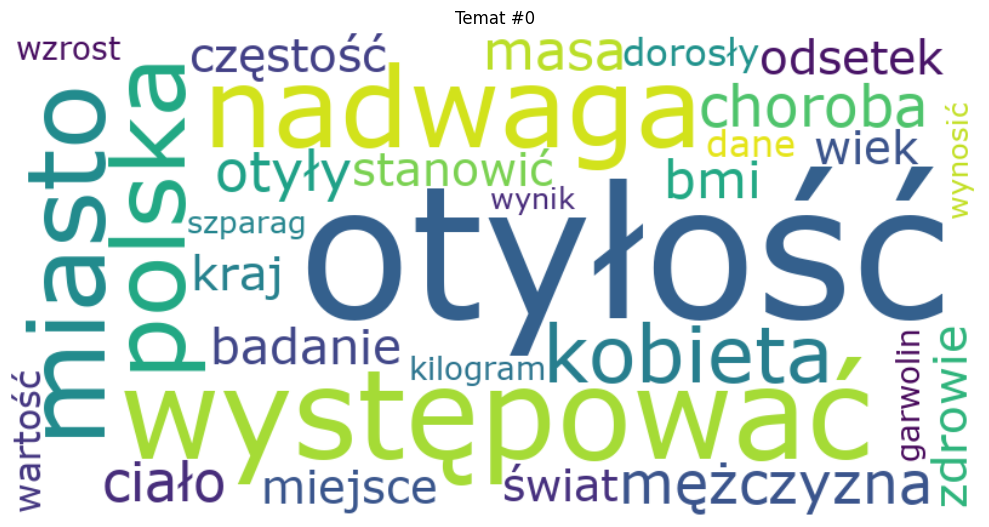

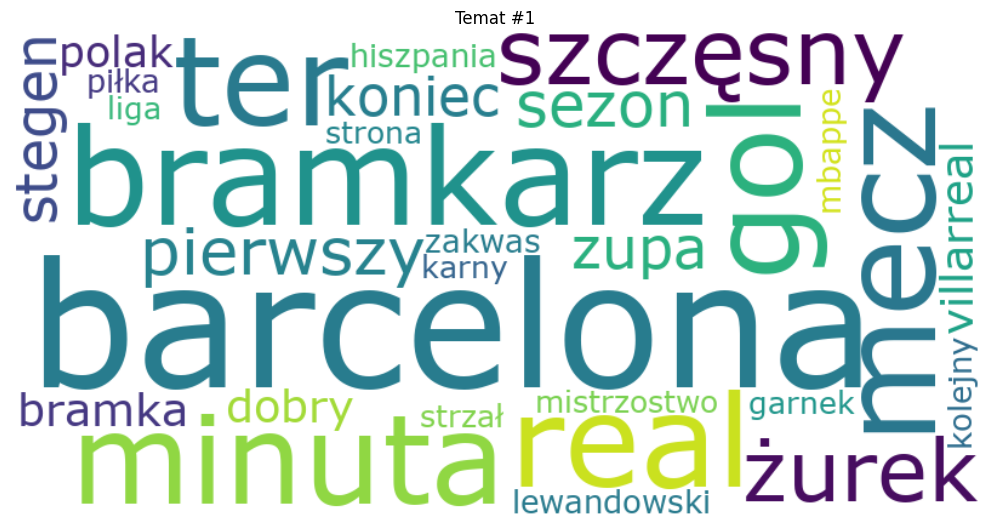

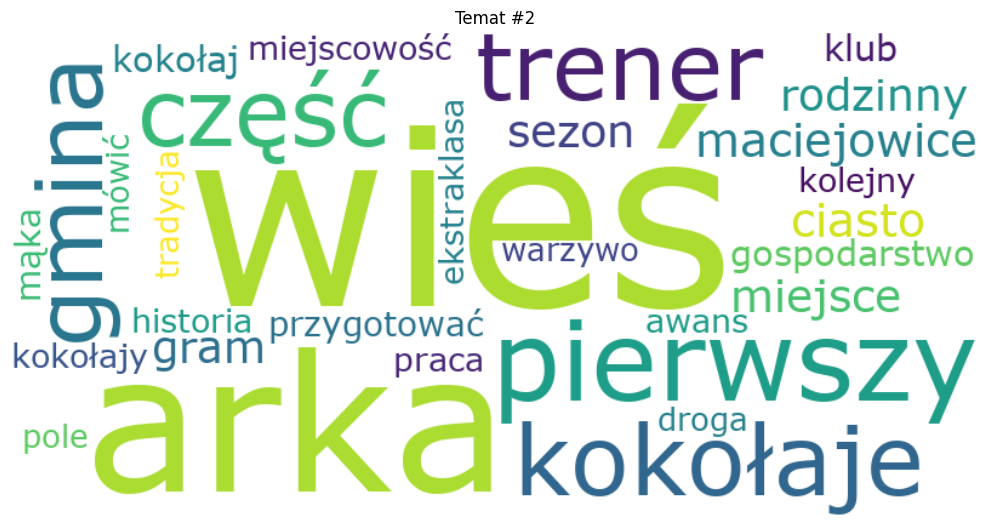

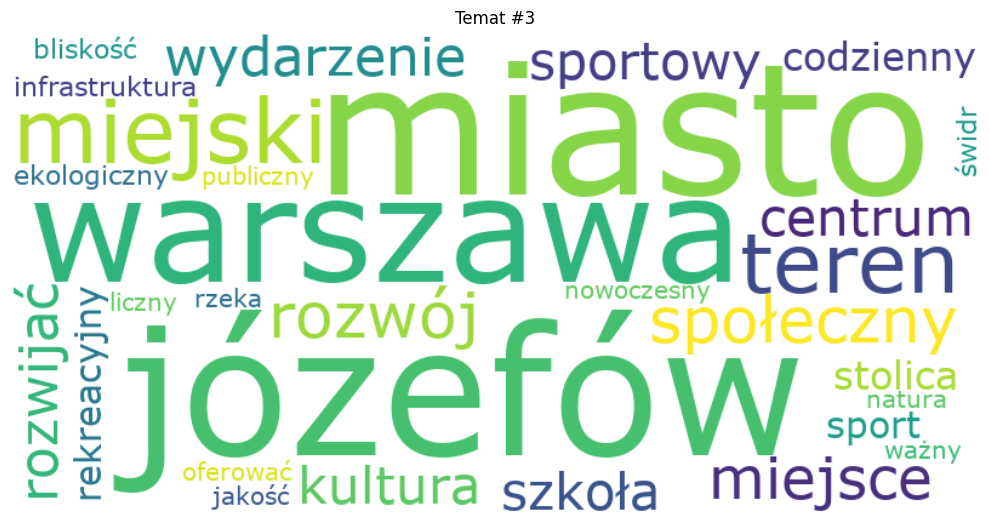

In [22]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Utwórz katalog na wyniki, jeśli nie istnieje
import os
if not os.path.exists('./results/wordclouds'):
    os.makedirs('./results/wordclouds')

# Generuj chmury słów dla każdego tematu
plt.figure(figsize=(12, 8))
for topic_id in range(num_topics):
    # Pobierz słowa tematu i ich wagi
    topic_words = dict(lda_model.show_topic(topic_id, topn=30))
    
    # Generuj chmurę słów
    wordcloud = WordCloud(
        width=800, 
        height=400, 
        background_color='white',
        colormap='viridis',
        contour_width=3,
        contour_color='steelblue',
        font_path='verdana'  # Użyj czcionki wspierającej polskie znaki
    ).generate_from_frequencies(topic_words)
    
    # Zapisz i pokaż
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Temat #{topic_id}')
    plt.tight_layout()
    plt.savefig(f'./results/wordclouds/temat_{topic_id}.png')
    plt.show()

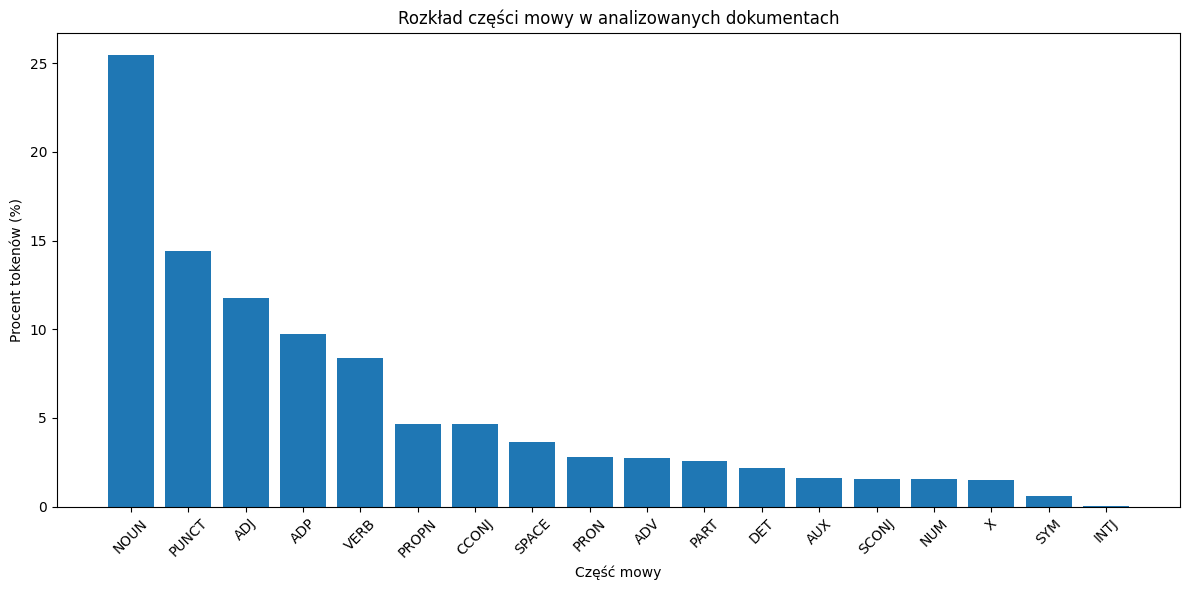

In [15]:
# Analiza części mowy w dokumentach
pos_counts = {}
for txt in nlp.pipe(corpus['document']):
    for token in txt:
        if token.pos_ not in pos_counts:
            pos_counts[token.pos_] = 0
        pos_counts[token.pos_] += 1

# Pokaż statystyki części mowy
total = sum(pos_counts.values())
sorted_pos = sorted(pos_counts.items(), key=lambda x: x[1], reverse=True)
plt.figure(figsize=(12, 6))
labels, values = zip(*sorted_pos)
plt.bar(labels, [v/total*100 for v in values])
plt.ylabel('Procent tokenów (%)')
plt.xlabel('Część mowy')
plt.title('Rozkład części mowy w analizowanych dokumentach')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('./results/pos_distribution.png')
plt.show()

In [20]:
# Znajdź najbardziej reprezentatywne dokumenty dla każdego tematu
representative_docs = {}
for topic_id in range(num_topics):
    # Oblicz "czystość" każdego dokumentu względem tego tematu
    topic_purity = []
    for i, doc in enumerate(dtm):
        topic_dist = lda_model.get_document_topics(doc, minimum_probability=0)
        # Znajdź wagę tego tematu w dokumencie
        weight = 0
        for t, w in topic_dist:
            if t == topic_id:
                weight = w
                break
        topic_purity.append((i, weight))
    
    # Posortuj dokumenty według wagi tematu
    sorted_docs = sorted(topic_purity, key=lambda x: x[1], reverse=True)
    representative_docs[topic_id] = sorted_docs[:3]  # Pierwsze 3 dokumenty

# Wyświetl wyniki
for topic_id, docs in representative_docs.items():
    print(f"\nTemat #{topic_id} - Najbardziej reprezentatywne dokumenty:")
    topic_terms = [term for term, _ in lda_model.show_topic(topic_id, topn=5)]
    print(f"Główne słowa: {', '.join(topic_terms)}")
    
    for doc_idx, weight in docs:
        print(f"  - {files[doc_idx]} (waga: {weight:.4f})")


Temat #0 - Najbardziej reprezentatywne dokumenty:
Główne słowa: otyłość, występować, nadwaga, miasto, polska
  - 10 - Otyłość i jej konsekwencje.txt (waga: 0.9989)
  - 08 - Trendy w występowaniu nadwagi w Polsce.txt (waga: 0.9988)
  - 07 - Epidemiologia otyłości na świecie i w Polsce.txt (waga: 0.9987)

Temat #1 - Najbardziej reprezentatywne dokumenty:
Główne słowa: barcelona, bramkarz, mecz, real, minuta
  - 13 - Oto dlaczego Wojciech Szczęsny musi odejść z Barcelony.txt (waga: 0.9991)
  - 15 - Lewy bez gola, Szczęsny bez gry. Barcelona przegrywa i świętuje.txt (waga: 0.9980)
  - 18 - Żurek wegetariański.txt (waga: 0.9978)

Temat #2 - Najbardziej reprezentatywne dokumenty:
Główne słowa: wieś, arka, pierwszy, kokołaje, część
  - 05 - Kokołaje.txt (waga: 0.9994)
  - 14 - Pertkiewicz Nawet nie bierzemy pod uwagę transferów gotówkowych [WYWIAD].txt (waga: 0.9992)
  - 19 - Calzone.txt (waga: 0.9985)

Temat #3 - Najbardziej reprezentatywne dokumenty:
Główne słowa: miasto, józefów, warszawa

In [10]:
import ipywidgets as widgets
from IPython.display import display, HTML

# Utwórz widżet do interaktywnego przeglądania tematów
def show_topic_explorer(lda_model, files, dtm, num_topics):
    # Funkcja do wyświetlania szczegółów tematu
    def on_topic_change(change):
        if change['type'] == 'change' and change['name'] == 'value':
            topic_id = change['new']
            output.clear_output()
            with output:
                # Pokaż najważniejsze słowa
                print(f"Temat #{topic_id}:")
                print("\nNajważniejsze słowa:")
                for term, weight in lda_model.show_topic(topic_id, topn=15):
                    print(f"  - {term}: {weight:.4f}")
                
                # Pokaż najlepsze dokumenty
                print("\nNajbardziej reprezentatywne dokumenty:")
                topic_docs = []
                for i, doc in enumerate(dtm):
                    topic_dist = lda_model.get_document_topics(doc)
                    for t, w in topic_dist:
                        if t == topic_id:
                            topic_docs.append((i, w))
                            break
                
                # Posortuj i pokaż
                topic_docs.sort(key=lambda x: x[1], reverse=True)
                for i, (doc_idx, weight) in enumerate(topic_docs[:5]):
                    if i < len(files):
                        print(f"  - {files[doc_idx]} (waga: {weight:.4f})")
    
    # Utwórz widżet wyboru tematu
    topic_dropdown = widgets.Dropdown(
        options=[(f"Temat #{i}", i) for i in range(num_topics)],
        value=0,
        description='Wybierz temat:',
        style={'description_width': 'initial'}
    )
    
    output = widgets.Output()
    topic_dropdown.observe(on_topic_change)
    
    # Wywołaj raz, aby pokazać pierwszy temat
    on_topic_change({'type': 'change', 'name': 'value', 'new': 0})
    
    # Zwróć kompletny widżet
    return widgets.VBox([topic_dropdown, output])

# Użyj widżetu
explorer = show_topic_explorer(lda_model, files, dtm, num_topics)
display(explorer)

In [28]:
# Pokaż tematy z ich najważniejszymi słowami
print("Tematy LDA:")
for idx, topic in lda_model.print_topics(num_words=10):
    print(f"Temat #{idx}: {topic}")

# Pokaż dokumenty i ich przypisanie do tematów
print("\nPrzypisanie dokumentów do tematów:")
for i, doc in enumerate(dtm):
    if i < len(files):  # Upewnij się, że indeks nie wychodzi poza zakres
        print(f"\nDokument: {files[i]}")
        topic_dist = lda_model.get_document_topics(doc)
        # Posortuj po wadze tematu
        sorted_topics = sorted(topic_dist, key=lambda x: x[1], reverse=True)
        for topic_id, weight in sorted_topics:
            if weight > 0.1:  # Pokaż tylko tematy z wagą > 10%
                print(f"  - Temat #{topic_id} (waga: {weight:.4f})")
                # Pokaż słowa tego tematu
                topic_words = [word for word, _ in lda_model.show_topic(topic_id, topn=5)]
                print(f"    Słowa: {', '.join(topic_words)}")

Tematy LDA:
Temat #0: 0.039*"otyłość" + 0.019*"występować" + 0.018*"osoba" + 0.015*"rok" + 0.013*"mężczyzna" + 0.013*"otyły" + 0.013*"kobieta" + 0.011*"częstość" + 0.010*"nadwaga" + 0.009*"kraj"
Temat #1: 0.017*"szparag" + 0.012*"móc" + 0.012*"krok" + 0.012*"jajka" + 0.012*"garnek" + 0.011*"makaron" + 0.010*"boczek" + 0.010*"minuta" + 0.010*"woda" + 0.010*"porada"
Temat #2: 0.010*"real" + 0.008*"stary" + 0.008*"gol" + 0.007*"zabytek" + 0.007*"udać" + 0.007*"mbappe" + 0.007*"rekord" + 0.006*"kolejny" + 0.006*"polski" + 0.006*"francuz"
Temat #3: 0.010*"real" + 0.008*"wrocław" + 0.008*"krzysztof" + 0.008*"warszawa" + 0.007*"pierwszy" + 0.006*"mallorca" + 0.006*"barcelona" + 0.005*"miejsce" + 0.005*"dzień" + 0.005*"miasto"

Przypisanie dokumentów do tematów:

Dokument: 01 - Kraków.txt
  - Temat #2 (waga: 0.9959)
    Słowa: real, stary, gol, zabytek, udać

Dokument: 02 - Warszawa.txt
  - Temat #3 (waga: 0.9951)
    Słowa: real, wrocław, krzysztof, warszawa, pierwszy

Dokument: 03 - Wrocław.

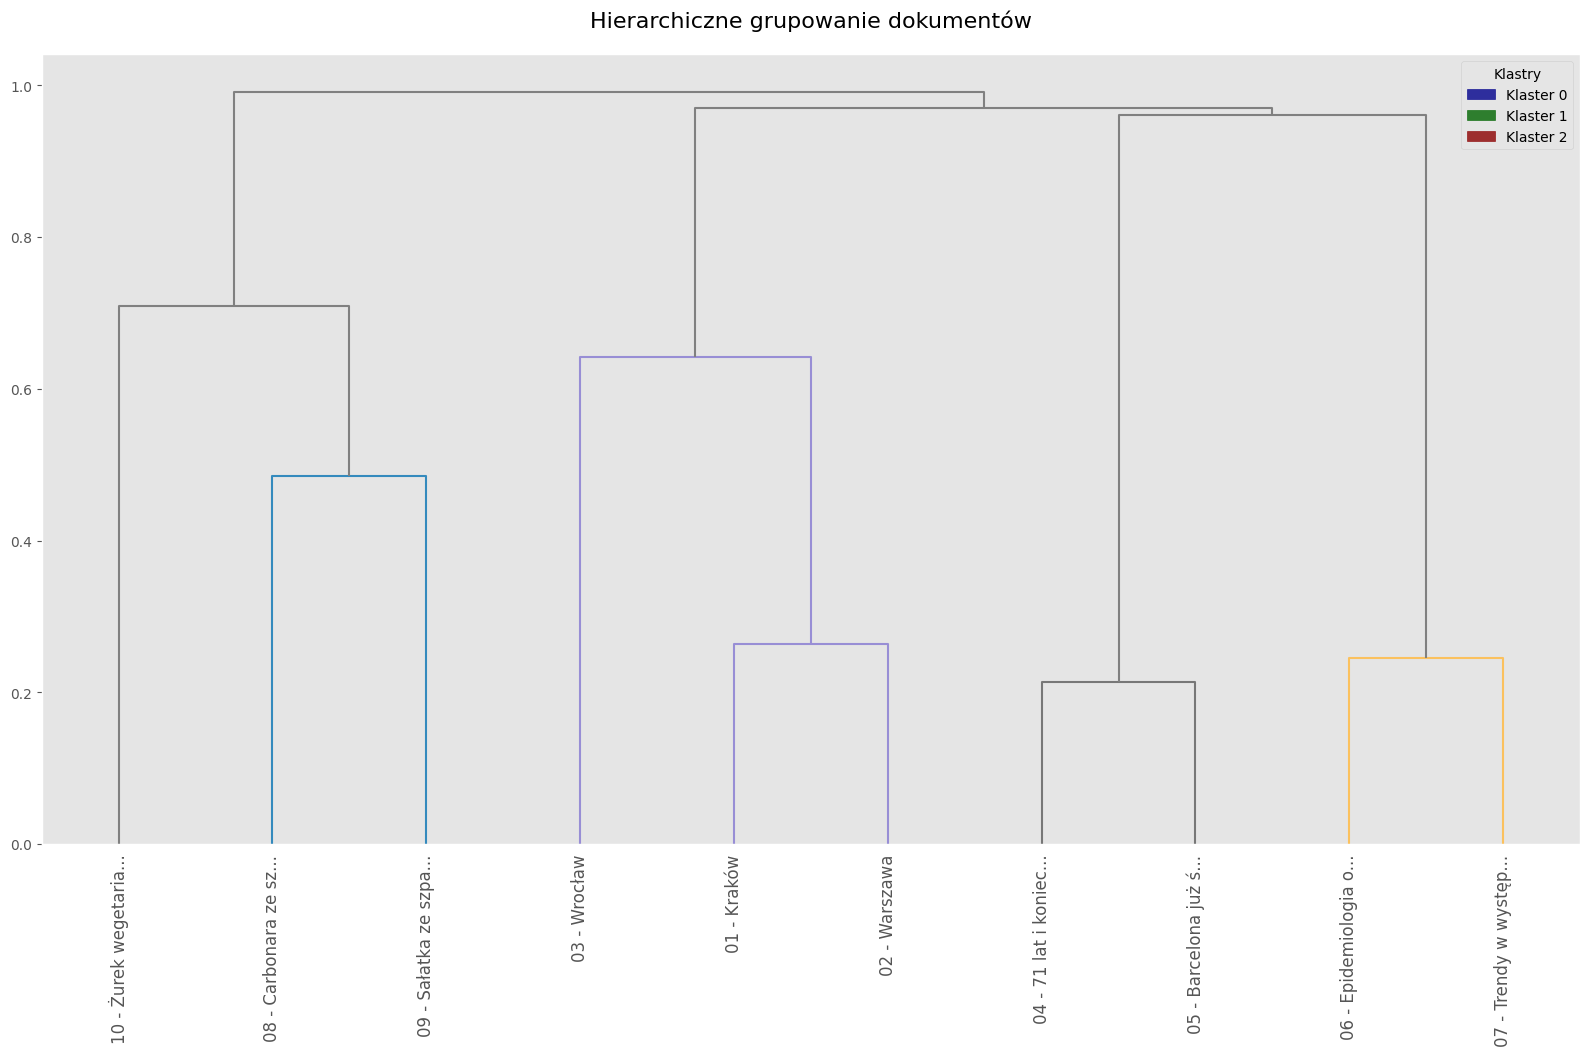

In [34]:
from scipy.cluster.hierarchy import linkage, dendrogram
import matplotlib.pyplot as plt
import numpy as np
import matplotlib

# Ustaw większy rozmiar czcionki i lepszy styl wykresu
plt.rcParams.update({'font.size': 12})
matplotlib.rcParams['figure.figsize'] = (14, 10)
matplotlib.style.use('ggplot')

# Skróć nazwy plików do bardziej czytelnych etykiet
def shorten_filename(filename):
    # Usuń rozszerzenie .txt
    name = filename.replace('.txt', '')
    # Skróć do pierwszych 20 znaków + ...
    if len(name) > 20:
        return name[:20] + '...'
    return name

# Utwórz krótsze etykiety dla dokumentów
labels = [shorten_filename(f) for f in files if not f.startswith('.')]

# Oblicz linkage
Z = linkage(X.toarray(), method='average', metric='cosine')

# Utwórz kolory dla różnych klastrów
cluster_colors = {0: 'darkblue', 1: 'darkgreen', 2: 'darkred'}
cluster_colors_list = [cluster_colors[c] for c in clusters]

# Rysuj dendrogram z kolorami
plt.figure(figsize=(16, 10))
plt.title('Hierarchiczne grupowanie dokumentów', fontsize=16, pad=20)

# Tworzenie dendrogramu z kolorowymi liśćmi
dendrogram(
    Z,
    leaf_rotation=90,  # Obróć etykiety
    leaf_font_size=12,  # Rozmiar czcionki etykiet
    labels=labels,      # Krótsze etykiety
    above_threshold_color='gray',
    orientation='top'   # Skieruj drzewo od góry do dołu
)



# Dodaj legendę
legend_elements = [plt.Rectangle((0,0), 1, 1, color=color, alpha=0.8) 
                  for color in cluster_colors.values()]
plt.legend(legend_elements, [f"Klaster {i}" for i in cluster_colors.keys()], 
           loc='upper right', title="Klastry")

# Popraw układ
plt.tight_layout()
plt.subplots_adjust(bottom=0.15)  # Więcej miejsca na dole dla etykiet
plt.grid(False)  # Usuń siatkę, żeby był bardziej czytelny

# Zapisz i pokaż
plt.savefig('./results/document_clustering_improved.png', dpi=300, bbox_inches='tight')
plt.show()